## 2. Исправление опечаток.

На основе [статьи](http://norvig.com/spell-correct.html) *Питера Норвига, Google*

### 2.1. Набор слов

In [109]:
import re
import math
import pickle
import string
from collections import Counter
import matplotlib.pyplot as plt
import requests
from download_text import get_grams_from_text
from corus.sources.meta import METAS
from corus.readme import format_metas, show_html, patch_readme
from corus import load_lenta

Прежде чем что-то делать со словами(править опечатки, например), надо эти слова откуда-то взять. Придется найти некий текст, возможно - из файла, а возможно - лежащий где-то на просторах интернета. Затем нужно этот текст разбить на слова.

Будем делать это с помощью библиотеки `corus`, в которой содержатся ссылки для скачивания огромного количества текста.

```python
html = format_metas(METAS)
show_html(html)
```

```bash
!wget -P ~/IHaskell/word_data/ https://github.com/dialogue-evaluation/GramEval2020/archive/master.zip
```

Получим уникальные слова, использовавшиеся в газете `lenta-ru`.

In [60]:
g = get_grams_from_text(path='../../../word_data/lenta-ru-news.csv.gz',
                        n=1, 
                        amount_of_sentense=100000, 
                        show_how_much=5000, 
                        delete_stop_words=False)

Sentence 5000
Sentence 10000
Sentence 15000
Sentence 20000
Sentence 25000
Sentence 30000
Sentence 35000
Sentence 40000
Sentence 45000
Sentence 50000
Sentence 55000
Sentence 60000
Sentence 65000
Sentence 70000
Sentence 75000
Sentence 80000
Sentence 85000
Sentence 90000
Sentence 95000


Сохраним слова в файл, чтобы не тратить время на загрузку.

In [110]:
pickle.dump(g, open("../../../word_data/words.pkl", "wb"))

In [111]:
w = pickle.load(open("../../../word_data/words.pkl", "rb"))

In [117]:
assert len(w[1]) == len(g[1])

Ниже - функция, ищущая слова в тексте и приводящая в нижний регистр.

In [61]:
def tokens(text):
    """Возвращает список токенов (подряд идущих буквенных последовательностей) в тексте. 
       Текст при этом приводится к нижнему регистру."""
    return re.findall(r'[a-z]+', text.lower())

In [62]:
WORDS = g[1]
len(WORDS)

337838

Мы создали список *WORDS* - список слов в том порядке, как они следуют в *TEXT*. Мы можем использовать этот список в качестве порождающей модели (*generative model*) текста. 

Язык - очень сложная штука и мы создаем крайне упрощенную модель языка, которая может ухватить часть этой сложной структуры. В модели мешка слов , мы полностью игнорируем порядок слов, зато соблюдаем их частоту. Представить это можно себе так: вы берете все слова текста и забрасываете их в мешок. Теперь, если вы хотите сгенерировать предложение с помощью этого мешка, вы просто трясете его(слова там перемешиваются) и достаете указанное количество слов по одному (мешок непрозрачный, так что слоа вы достаете наугад). Почти наверное полученное предложение будет грамматически некорректным, но слова в этом предложении будут в +- правильной пропорции (более частые будут встречаться чаще, более редкие - реже). 

Другое представление мешка слов - *Counter*. Это словарь, состоящий из пар **{'слово': кол-во вхождений слова в текст}**. Например,

In [66]:
print(WORDS.most_common(10))

[('в', 843830), ('и', 369440), ('на', 331820), ('что', 206379), ('с', 185611), ('по', 176561), ('не', 126844), ('из', 102809), ('за', 85195), ('этом', 83369)]


#### Закон Ципфа

В 1935, лингвист Джордж Ципф отметил, что в любом большом тексте $n$-тое наиболее часто встречающееся слово появляется с частотой ~$\frac{1}{n}$ от частоты наиболее часто встречающегося слова. Это наблюдение получило название **Закона Ципфа**, несмотря на то, что Феликс Ауэрбах заметил это еще в 1913 году. 

Если нарисовать частоты слов, начиная от самого часто встречающегося, на *log-log-графике*, они должны приблизительно следовать прямой линии, если *закон Ципфа* верен. Для нашего случая все, вроде бы, `+-` совпадает:

In [80]:
M = WORDS['в']
counts = [c for (w, c) in WORDS.most_common()]
probs = [M / word for word in range(1, len(WORDS) + 1)]

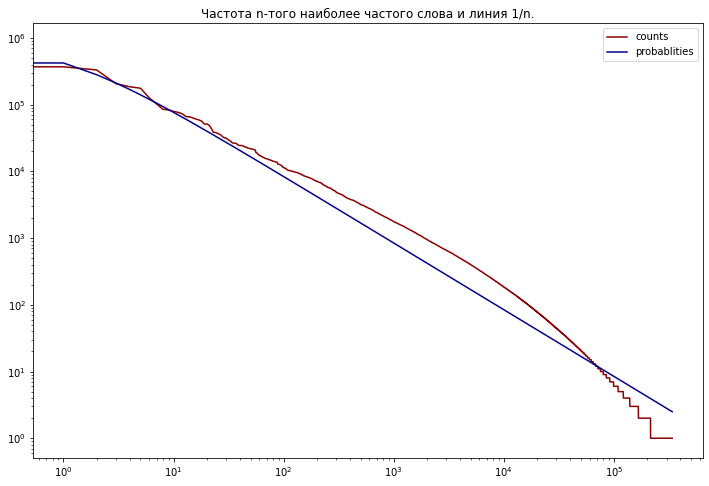

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

ax.plot(counts, color='darkred', label='counts')
ax.plot(probs, color='darkblue', label='probablities')

ax.set_yscale('log') 
ax.set_xscale('log')
ax.set_title('Частота n-того наиболее частого слова и линия 1/n.')
ax.legend()
plt.show()

## 2.2. `Peter Norvig Spellchecker`

In [90]:
ALPHABET = {'ENG': 'abcdefghijklmnopqrstuvwxyz',
            'RUS': 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'}
COUNTS = WORDS

**Постановка задачи**:

Для данного слова $w$ нужно найти наиболее вероятную правку `c = correct(w)`. Для этого необходимо найти всех кандидатов $c$, которые достаточно **близкие** к $w$ и необходимо выбрать **наиболее вероятный** из них.

Осталось понять, что такое *близкие* и *наиболее вероятный*.

**Применим наивный подход:** всегда будем брать более близкое слово, если проверки на близость недостаточно, берем слово с максимальной частотой из WORDS. 

Сейчас мы будем измерять близость с помощью расстояния Левенштейна: минимального необходимого количества удалений, перестановок, вставок, и замен символов, необходимых чтобы одно слово превратить в другое. 

Конечно же это не единственный возможный подход. Методом проб и ошибок можно понять, что поиск слов в пределах расстояния `edit_distance = 2` уже даст пристойные результаты (или можно почитать в литературе). Тогда остается определить функцию `correct(w)`:

In [91]:
def correct(word):
    """
    Поиск лучшего исправления ошибки для данного слова.
    
    :param word: слово для исправления
    :return: предрассчитать edit_distance == 0, затем 1, затем 2; в противном случае оставить слово "как есть"
    """
    candidates = (known(edits0(word)) or 
                  known(edits1(word)) or 
                  known(edits2(word)) or 
                  [word])
    return max(candidates, key=COUNTS.get)

Функции `known` и `edits0` простые, функция `edits2` легко получаются из функции `edits1`:

In [92]:
def known(words):
    "Вернуть подмножество слов, которое есть в нашем словаре."
    return {w for w in words if w in COUNTS}

def edits0(word): 
    "Вернуть все строки, которые находятся на edit_distance == 0 от word (т.е., просто само слово)."
    return {word}

def edits2(word):
    "Вернуть все строки, которые находятся на edit_distance == 2 от word."
    return {e2 for e1 in edits1(word) for e2 in edits1(e1)}

Функция `edits1(word)`должна возвращать множество слов, находящихся на расстоянии edit_distance == 1. Например для слова `"wird"` это множество будет включать слова `"weird"` (вставка буквы `e`) и слово `"word"` (замена `i` на `o`), , а также `"iwrd"` (перемена `w` и `i` местами); после чего может быть применена функция `known` для фильтрации и выбора подходящих кандидатов).Например можно *разбить* исходное слово на пару всеми возможными способами (каждое *разбиение* даст нам пару "слов"), `(a, b)`, первая часть - до места разбиения, а вторая - после, и в каждом месте разбиения можно: удалить, поменять местами, заменить или вставить букву:

<table>
  <tr><td> пары: <td><tt> Ø+wird <td><tt> w+ird <td><tt> wi+rd <td><tt>wir+d<td><tt>wird+Ø<td><i>Notes:</i><tt> (<i>a</i>, <i>b</i>)</tt> пара</i>
  <tr><td> удаления: <td><tt>Ø+ird<td><tt> w+rd<td><tt> wi+d<td><tt> wir+Ø<td><td><i>Удаление первой буквы в b</i>
  <tr><td> перемена мест: <td><tt>Ø+iwrd<td><tt> w+rid<td><tt> wi+dr</tt><td><td><td><i>Перемена мест двух первых букв b
  <tr><td> замена: <td><tt>Ø+?ird<td><tt> w+?rd<td><tt> wi+?d<td><tt> wir+?</tt><td><td><i>замена буквы в начале b
  <tr><td> вставка: <td><tt>Ø+?+wird<td><tt> w+?+ird<td><tt> wi+?+rd<td><tt> wir+?+d<td><tt> wird+?+Ø</tt><td><i>Вставка буквы между a и b
</table>

In [93]:
def edits1(word):
    "Возвращает список всех строк на расстоянии edit_distance == 1 от word."
    pairs      = splits(word)
    deletes    = [a+b[1:]           for (a, b) in pairs if b]
    transposes = [a+b[1]+b[0]+b[2:] for (a, b) in pairs if len(b) > 1]
    replaces   = [a+c+b[1:]         for (a, b) in pairs for c in alphabet if b]
    inserts    = [a+c+b             for (a, b) in pairs for c in alphabet]
    return set(deletes + transposes + replaces + inserts)

def splits(word):
    "Возвращает список всех возможных разбиений слова на пару (a, b)."
    return [(word[:i], word[i:]) 
            for i in range(len(word)+1)]

alphabet = ALPHABET['RUS']

Проверим на примерах

In [103]:
print(splits('птца'))
print(len(alphabet))
print(edits0('птца'))
print(list(edits1('птца'))[:10])
print(len(edits2('птца')))

[('', 'птца'), ('п', 'тца'), ('пт', 'ца'), ('птц', 'а'), ('птца', '')]
33
{'птца'}
['птце', 'птра', 'птица', 'пёца', 'птфа', 'птмца', 'пдца', 'птеца', 'аптца', 'птцш']
39332


Теперь напишем функцию для вывода исправленных ошибок в тексте.

In [105]:
def correct_text(text, language='rus'):
    "Исправить все слова с опечатками в тексте."
    shab = '[a-zA-Z]+' if language == 'eng' else '[а-яА-Я]+'
    return re.sub(shab, correct_match, text)

def correct_match(match):
    "Исправить слово word в match-группе, сохранив регистр: upper/lower/title."
    word = match.group()
    return case_of(word)(correct(word.lower()))

def case_of(text):
    "Возвращает функцию регистра по тексту: upper, lower, title, или str."
    return (str.upper if text.isupper() else
            str.lower if text.islower() else
            str.title if text.istitle() else
            str)

In [107]:
correct_text('Я бы не хоетл задаваться вопрсом. Чот ты здес длаешь?')

'Я бы не хотел задаваться вопросом. Что ты здесь делаешь?'

**Links**:

- [Текст с ошибками](https://yandex.ru/search/?text=Efficient%20Dependency%20Parsing%20In%20Case%20Of%20Ungrammatical%20Sentences&clid=2411726&lr=2)
- [Распознавание текста с ошибками](https://ru.stackoverflow.com/questions/859694/%D0%A0%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0-%D1%81-%D0%BE%D1%88%D0%B8%D0%B1%D0%BA%D0%B0%D0%BC%D0%B8)
- [Опечатки с учетом контекста](https://habr.com/ru/post/346618/)
- [Spell-Corrector](http://norvig.com/spell-correct.html)
- [Project JetBrains](https://internship.jetbrains.com/projects/848/)
- [Supar](https://github.com/yzhangcs/parser)
- [Error-repair Dependency](https://www.aclweb.org/anthology/P17-2030.pdf)
- [Parser](https://github.com/HHashemi?tab=repositories)
- [Dependency Parser](https://medium.com/data-science-in-your-pocket/dependency-parsing-associated-algorithms-in-nlp-96d65dd95d3e)
- [Dependency NLP Parser](http://nlpprogress.com/english/dependency_parsing.html)
- [Error-repair Dependency Paper](https://www.researchgate.net/publication/318741850_Error-repair_Dependency_Parsing_for_Ungrammatical_Texts)
- [Исправление опечаток - эмбеддинги](https://habr.com/ru/company/singularis/blog/358664/)
- [Обзор открытых решений исправления опечаток](https://habr.com/ru/company/naumen/blog/463683/)
- [One more](https://savepearlharbor.com/?p=293440)
- [SpellChecker](https://github.com/pileyan/webinar_spellchecker)
- [SymSpell](https://github.com/wolfgarbe/symspell)
- [1000X Faster SymSpell](https://wolfgarbe.medium.com/1000x-faster-spelling-correction-algorithm-2012-8701fcd87a5f)